## Imports

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from netCDF4 import Dataset, num2date


## Convert nc files to csv

In [ ]:
data_year = ['2014','2015','2016','2017','2018','2019','2020']

for i in data_year:    
    a_hour = []
    a_day = []
    a_month = []
    a_year = []
    a_val = []

    satfile = Dataset(rf'LOCATION OF FILE'+'.nc', 'r')
    all_t2m = satfile.variables['ssrd'][:]
    nctime = satfile.variables['time'][:] # Isolate all time values
    t_unit = satfile.variables['time'].units # Isolate time units
    t_cal = satfile.variables['time'].calendar # Isolate time calendar
    satfile.close() # Close file
    satdate = [] # Initialise satellite dates list
    satdate.append(num2date(nctime, units = t_unit, calendar = t_cal))

    for k in range(len(all_t2m)):
        a_hour.append(int(satdate[0][k].strftime("%H")))
        a_day.append(int(satdate[0][k].strftime("%d")))
        a_month.append(int(satdate[0][k].strftime("%m")))
        a_year.append(int(satdate[0][k].strftime("%Y")))
        a_val.append(round(all_t2m[k,:,:][2][2]/(3600)))

    sat_df = pd.DataFrame(list(zip(a_year,a_month,a_day,a_hour,a_val)),columns=['Year','Month','Day','Hour','Val'])
    sat_df.to_csv(rf'Sat_Data/Dublin_sat_solar_radiation_{i}.csv')

** LAND_DF_DIRECTORY : Folder for ground based data

** SAT_DF_DIRECTORY: Folder for satellite data

In [31]:
LAND_DF_DIRECTORY = r'Land_data/Dublin_sat_solar_radiation_{}.csv'

SAT_DF_DIRECTORY = r'Sat_Data/Dublin_land_solar_radiation_{}.csv'

## Time-series Plots

In [32]:
data_year = ['2014','2015','2016','2017','2018','2019','2020']
ls_land_dfs = []
ls_sat_dfs = []

for i in data_year:  
    sat_df = pd.read_csv(LAND_DF_DIRECTORY.format(i),index_col = 0)
    df_land = pd.read_csv(SAT_DF_DIRECTORY.format(i),index_col = 0)
    df_land = df_land.rename(columns={'[W/m2]': 'Val'})
    sat_solar_rad = sat_df['Val'].to_list()
    land_solar_rad = df_land['Val'].to_list()

    ls_init_vals = [sat_solar_rad,land_solar_rad]
    ls_dfs = []
    ls_final_vals = []

    for j in ls_init_vals:

        new_df = sat_df.copy()
        new_df['solar_diff'] = j
        new_df = new_df.drop(new_df.columns[4],axis=1)

        solar_diff_hour_df = new_df[new_df.Hour==12]
        solar_diff_hour_df = solar_diff_hour_df.drop(solar_diff_hour_df.columns[3],axis=1)
        solar_diff_hour_df.reset_index(drop=True, inplace=True)

        solar_diff_mean_lst = new_df.groupby(['Month','Day'])['solar_diff'].mean().to_list()
        solar_diff_hour_df['solar_diff'] = solar_diff_mean_lst

        ls_dfs.append(solar_diff_hour_df)

    ls_land_dfs.append(ls_dfs[1])
    ls_sat_dfs.append(ls_dfs[0])


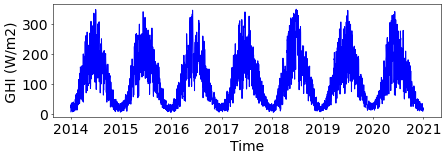

In [34]:
tdf_land = pd.concat(ls_land_dfs)
tdf_land['date'] = pd.to_datetime(tdf_land[["Year", "Month", "Day"]])
tdf_land.drop(tdf_land.columns[[0,1, 2]], axis=1, inplace=True)
tdf_land.reset_index(drop=True, inplace=True)

t_data = tdf_land['solar_diff']
t_data.index = tdf_land['date']

plt.figure(figsize=(10,3), dpi=50)
plt.plot(t_data,color='blue')
plt.xlabel('Time')
plt.ylabel(' GHI (W/m2) ')
plt.rcParams.update({'font.size': 20})
plt.savefig('land.pdf', bbox_inches = 'tight', pad_inches = 0.05)

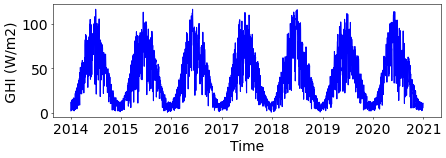

In [35]:
tdf_sat = pd.concat(ls_sat_dfs)
tdf_sat['date'] = pd.to_datetime(tdf_sat[["Year", "Month", "Day"]])
tdf_sat.drop(tdf_sat.columns[[0,1, 2]], axis=1, inplace=True)
tdf_sat.reset_index(drop=True, inplace=True)

t_data = tdf_sat['solar_diff']
t_data.index = tdf_sat['date']

plt.figure(figsize=(10,3), dpi=50)
plt.plot(t_data,color='blue')
plt.xlabel('Time')
plt.ylabel(' GHI (W/m2) ')
plt.rcParams.update({'font.size': 20})
plt.savefig('sat.pdf', bbox_inches = 'tight', pad_inches = 0.05)

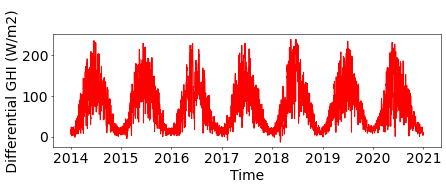

In [36]:
data_year = ['2014','2015','2016','2017','2018','2019','2020']
full_month_df = []
for i in data_year:  
    sat_df = pd.read_csv(LAND_DF_DIRECTORY.format(i),index_col = 0)
    df_land = pd.read_csv(SAT_DF_DIRECTORY.format(i),index_col = 0)                                
    sat_solar_rad = sat_df['Val'].to_list()
    land_solar_rad = df_land['[W/m2]'].to_list()

    solar_diff = [a - b for a, b in zip(land_solar_rad, sat_solar_rad)]

    new_df = sat_df.copy()
    new_df['solar_diff'] = solar_diff
    new_df = new_df.drop(new_df.columns[4],axis=1)

    solar_diff_hour_df = new_df[new_df.Hour==12]
    solar_diff_hour_df = solar_diff_hour_df.drop(solar_diff_hour_df.columns[3],axis=1)
    solar_diff_hour_df.reset_index(drop=True, inplace=True)

    solar_diff_mean_lst = new_df.groupby(['Month','Day'])['solar_diff'].mean().to_list()
    solar_diff_hour_df['solar_diff'] = solar_diff_mean_lst
    full_month_df.append(solar_diff_hour_df)

tdf = pd.concat(full_month_df)
tdf['date'] = pd.to_datetime(tdf[["Year", "Month", "Day"]])
tdf.drop(tdf.columns[[0,1, 2]], axis=1, inplace=True)
tdf.reset_index(drop=True, inplace=True)
#tdf.index = tdf['date']

t_data = tdf['solar_diff']
t_data.index = tdf['date']

plt.figure(figsize=(10,3), dpi=50)
plt.plot(t_data,color='red')
#plt.title('Difference b/w Land & Satellite Irrdaiance')
#plt.xticks(rotation=30)
plt.xlabel('Time')
plt.ylabel(' Differential GHI (W/m2) ')
plt.rcParams.update({'font.size': 20})
plt.savefig('diff.pdf', bbox_inches = 'tight', pad_inches = 0.05)

## Mean Satellite and Land Radiation Difference

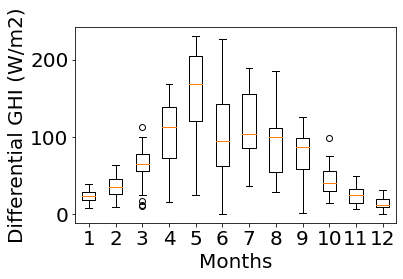

In [37]:
data_year = '2020'

sat_df = pd.read_csv(LAND_DF_DIRECTORY.format(i),index_col = 0)
df_land = pd.read_csv(SAT_DF_DIRECTORY.format(i),index_col = 0)
sat_solar_rad = sat_df['Val'].to_list()
land_solar_rad = df_land['[W/m2]'].to_list()

solar_diff = [a - b for a, b in zip(land_solar_rad, sat_solar_rad)]

new_df = sat_df.copy()
new_df['solar_diff'] = solar_diff
new_df = new_df.drop(new_df.columns[4],axis=1)

solar_diff_hour_df = new_df[new_df.Hour==12]
solar_diff_hour_df = solar_diff_hour_df.drop(solar_diff_hour_df.columns[3],axis=1)
solar_diff_hour_df.reset_index(drop=True, inplace=True)

solar_diff_mean_lst = new_df.groupby(['Month','Day'])['solar_diff'].mean().to_list()
solar_diff_hour_df['solar_diff'] = solar_diff_mean_lst

month_unq = solar_diff_hour_df.Month.unique()
plt_arr = []
for j in month_unq:
    plt_arr.append(solar_diff_hour_df[solar_diff_hour_df.Month==j].solar_diff.values)

plt.xlabel('Months')
plt.ylabel('Differential GHI (W/m2)')
plt.boxplot(plt_arr)
#plt.xticks(pos_ls,mth2)
plt.tight_layout()


plt.savefig('2020 - Dublin Mean Satellite and Land Radiation Difference.pdf', bbox_inches = 'tight', pad_inches = 0.05)

## Linear Regression

In [38]:
data_year = ['2014','2015','2016','2017','2018','2019','2020']
ls_df_years = []
ls_df_sat = []
ls_df_land = []

for i in data_year:  
    sat_df = pd.read_csv(LAND_DF_DIRECTORY.format(i),index_col = 0)
    df_land = pd.read_csv(SAT_DF_DIRECTORY.format(i),index_col = 0)
    df_land = df_land.rename(columns={'[W/m2]': 'Val'})
    
    ls_df_land.append(df_land)
    ls_df_sat.append(sat_df)
    
df_land_full = pd.concat(ls_df_land)
df_sat_full = pd.concat(ls_df_sat)

print(df_sat_full.shape)   
print(df_land_full.shape)   

df_sat_full.Val = df_sat_full.Val.shift(-3)
df_sat_full['Val'] = df_sat_full['Val'].fillna(0)

df_sat_full['Month'] = df_sat_full['Month'].map(str)
df_sat_full['Day'] = df_sat_full['Day'].map(str)
df_sat_full['Hour'] = df_sat_full['Hour'].map(str)

df_sat_full.drop(df_sat_full.columns[[0]], axis=1, inplace=True) 
print(df_sat_full.shape)   
print(df_sat_full.head())

idx = df_sat_full[df_sat_full.Val!=0].index

df_land_full = df_land_full.iloc[idx]
df_land_full.reset_index(inplace=True,drop=True)

df_sat_full = df_sat_full.iloc[idx]
df_sat_full.reset_index(inplace=True,drop=True)

idx = df_land_full[df_land_full.Val!=0].index
df_land_full = df_land_full.iloc[idx]
df_land_full.reset_index(inplace=True,drop=True)

df_sat_full = df_sat_full.iloc[idx]
df_sat_full.reset_index(inplace=True,drop=True)

(61368, 5)
(61368, 5)
(61368, 4)
  Month Day Hour  Val
0     1   1    0  0.0
1     1   1    1  0.0
2     1   1    2  0.0
3     1   1    3  0.0
4     1   1    4  0.0


Total samples == (29703, 4)
Month == 1
Number of samples == 1680
Train Score:  0.7887680737185068
Test Score:  0.7680046480308667
Month == 2
Number of samples == 1790
Train Score:  0.8668529994140199
Test Score:  0.8406093792739332
Month == 3
Number of samples == 2442
Train Score:  0.7977080289331139
Test Score:  0.7762335583535495
Month == 4
Number of samples == 2782
Train Score:  0.8508438093062948
Test Score:  0.8431955842744854
Month == 5
Number of samples == 3270
Train Score:  0.8138140566546508
Test Score:  0.7874987302518155
Month == 6
Number of samples == 3359
Train Score:  0.8504955848510305
Test Score:  0.8325000381555103
Month == 7
Number of samples == 3442
Train Score:  0.8283589524520094
Test Score:  0.8392457908856197
Month == 8
Number of samples == 3043
Train Score:  0.8149969193086761
Test Score:  0.844579797054986
Month == 9
Number of samples == 2540
Train Score:  0.8483251387417877
Test Score:  0.820454107605446
Month == 10
Number of samples == 2176
Train Score:  0.85

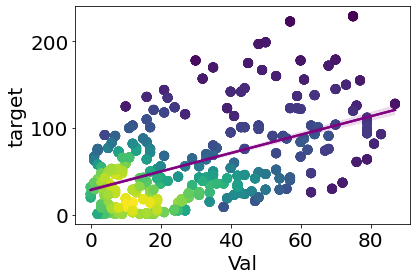

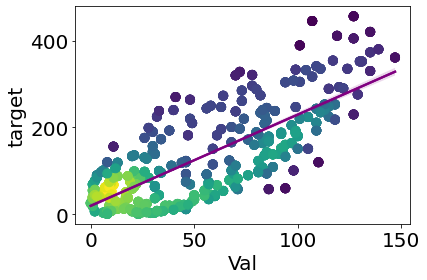

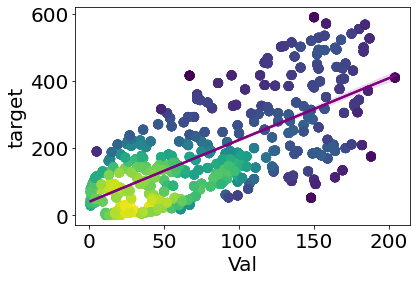

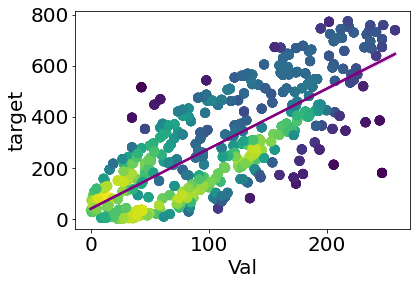

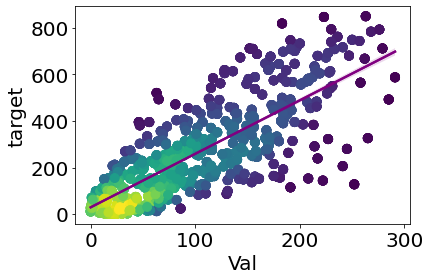

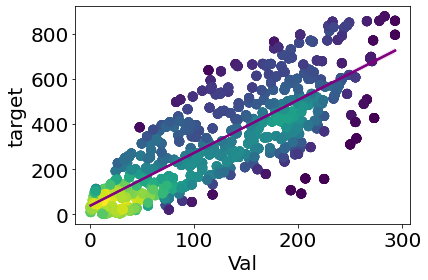

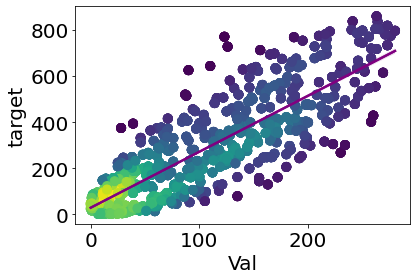

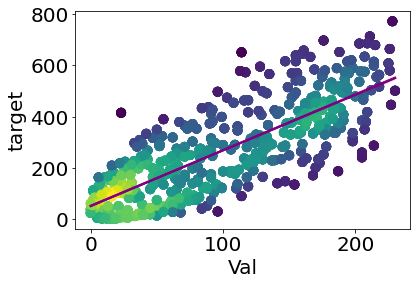

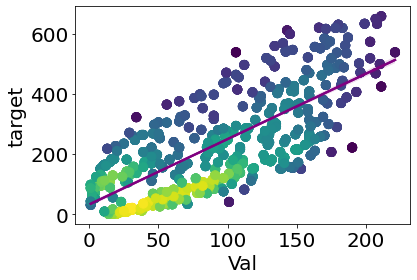

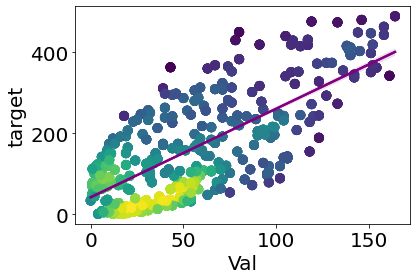

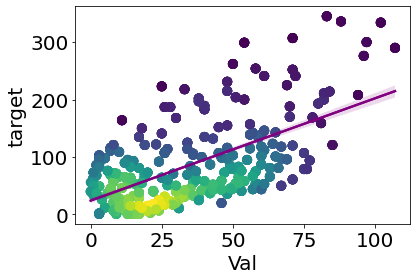

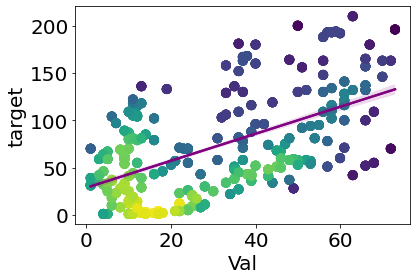

In [39]:
month_unq = df_sat_full.Month.unique()
each_mnth_sample = []
train_scores = []
test_scores = []

print('Total samples == ' + str(df_sat_full.shape))
for i in month_unq:
    iter = int(i)    
    X = df_sat_full[df_sat_full.Month==str(i)]
    X = pd.get_dummies(data=X)
    X['target'] = df_land_full[df_land_full.Month==iter].Val.values   
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=101) 

             
    y_train = X_train['target']
    X_train.drop('target',axis=1,inplace=True)

    y_test = X_test['target']
    X_test.drop('target',axis=1,inplace=True)

    # print(X_train.shape,y_train.shape)
    # print(X_test.shape,y_test.shape)
    print('Month == ' + i)

    reg1 = LinearRegression().fit(X_train,y_train)
    train_score = reg1.score(X_train,y_train)
    test_score  = reg1.score(X_test, y_test)
    predictions = reg1.predict(X_test)

    plt_val_2 = X['target']
    X.drop('target',axis=1,inplace=True)     
    plt_val_1 = X.Val

    print('Number of samples == ' + str(len(plt_val_2)))
    each_mnth_sample.append(len(plt_val_2))
    
    xy = np.vstack([plt_val_1,plt_val_2])
    z = gaussian_kde(xy)(xy)

    plt.figure()
    plt.scatter(plt_val_1,plt_val_2,c=z,s=80)
    sns.regplot(x = plt_val_1,y = plt_val_2,scatter = False,ci = 95, fit_reg=True,color='purple')
    sns.regplot(x = plt_val_1,y = plt_val_2,scatter = False,ci = 0, fit_reg=True,color='purple')
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    print('Train Score: ',train_score)
    print('Test Score: ',test_score)


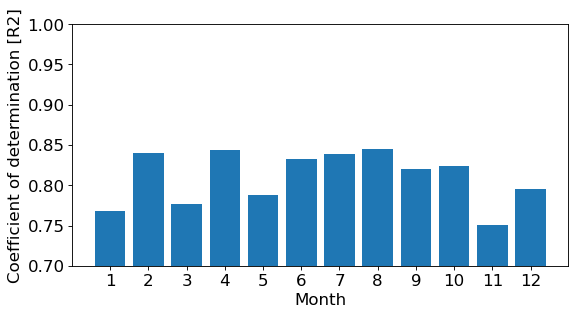

In [43]:
plt.figure(figsize=(8,4), dpi=80)
plt.bar(month_unq,test_scores)
plt.ylim((0.7,1))
plt.xlabel('Month')
plt.ylabel('Coefficient of determination [R2]')
plt.rcParams.update({'font.size': 15})
plt.savefig('R2-vals.pdf', bbox_inches = 'tight', pad_inches = 0.05)